# Object Matching

A primary use of object-based methods is the application to forecast verification. For example, we can identify storm objects in a convection-allowing model forecast and observed radar and match them together to measure forecast accuracy. In this brief tutorial, I show demostrate object matching in the MontePython module.



In [1]:
import sys, os 
sys.path.append(os.path.dirname(os.getcwd()))
import seaborn as sns
sns.set()

In [2]:
import monte_python

import numpy as np
import matplotlib.pyplot as plt

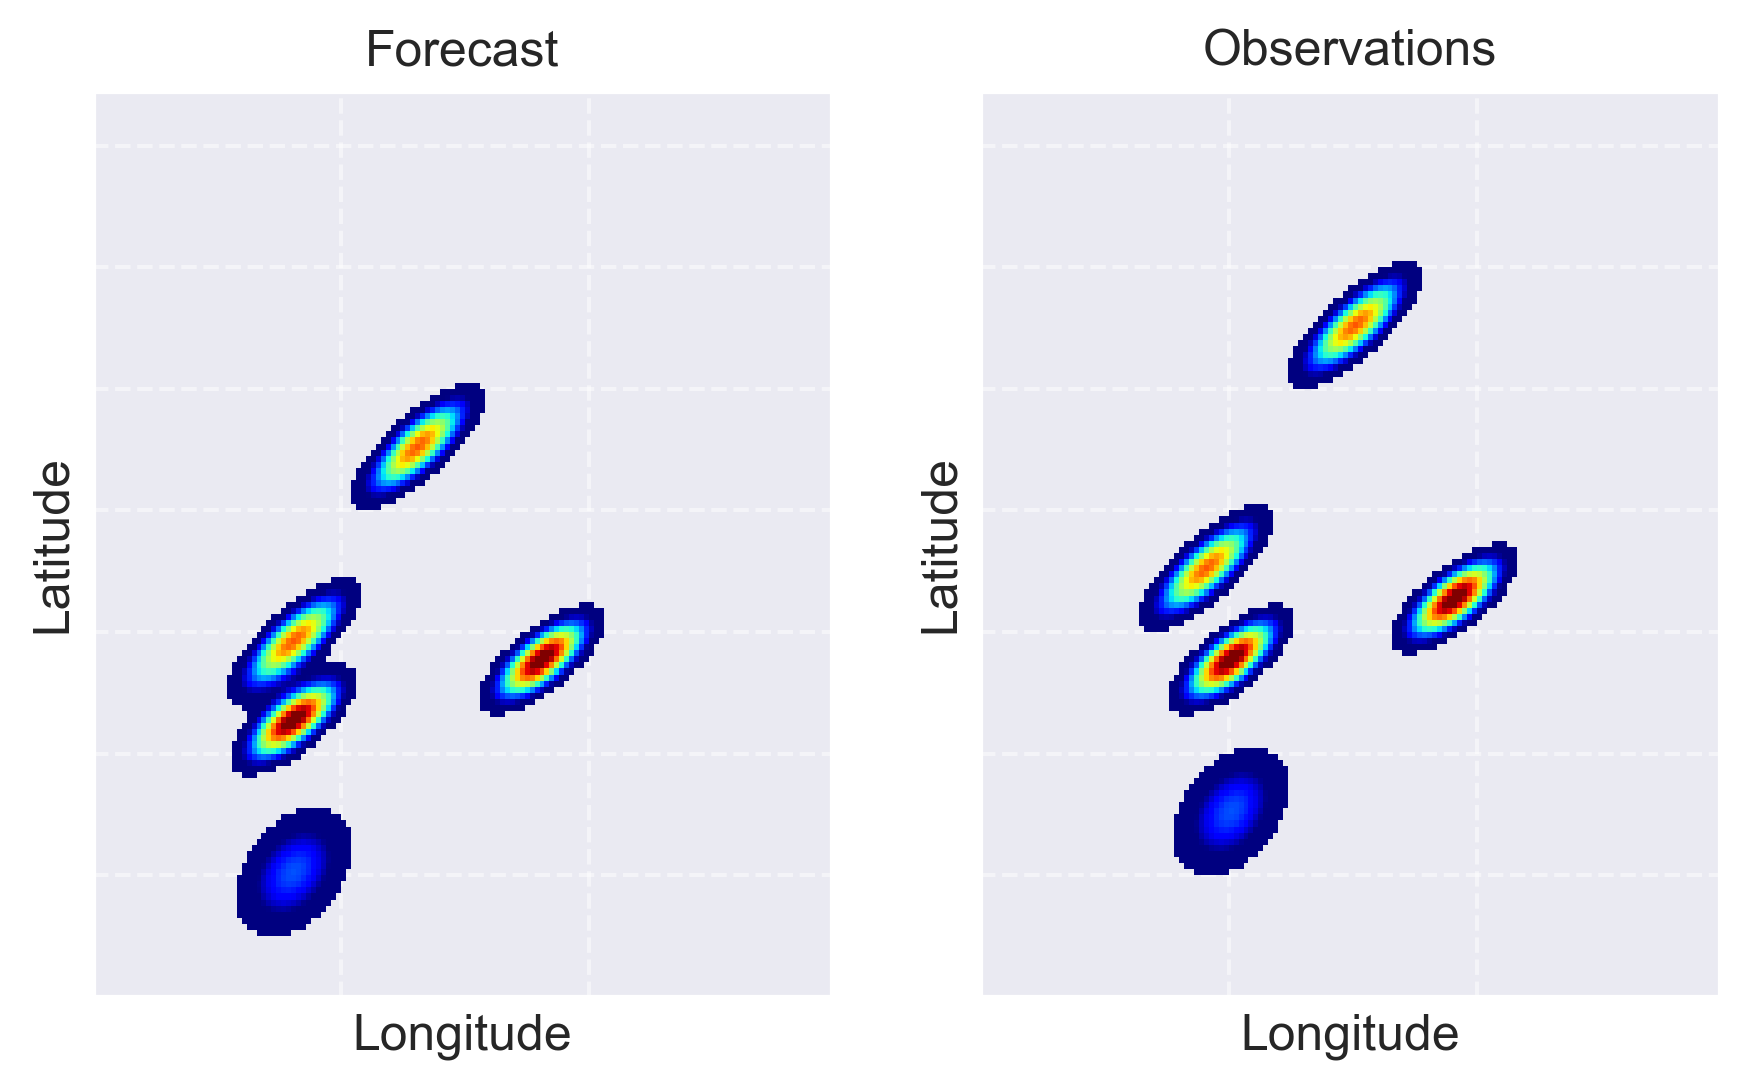

In [3]:
# Create fake storm data
forecast_centers = [(40, 45), (40, 58), (65, 90), (90, 55), (40,20)]
obs_centers = [(50, 55), (45, 70), (75, 110), (95, 65), (50,30)]

forecast_storms,x,y = monte_python.create_fake_storms(forecast_centers)
obs_storms,x,y = monte_python.create_fake_storms(obs_centers)

fig, axes = plt.subplots(ncols=2, figsize=(7,4), dpi=300, sharey=True)

for ax, storms, title in zip(axes.flat, [forecast_storms, obs_storms], ['Forecast', 'Observations']):
    ax.set_title(title)
    monte_python.plot_fake_storms(x,y,storms, ax=ax, colorbar=False)

In [4]:
# For this example, we are using two iterations of the iterative watershed method. 
# However, if the expected objects existed across more spatial scales, we could introduce more
# iterations. 
param_set = [ {'min_thresh':10,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 200,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':25,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

params = {'params': param_set }

labels = []
for storms in [forecast_storms, obs_storms]:
    input_data = np.where(storms > 10, storms, 0)
    storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )
    labels.append((storm_labels, object_props))

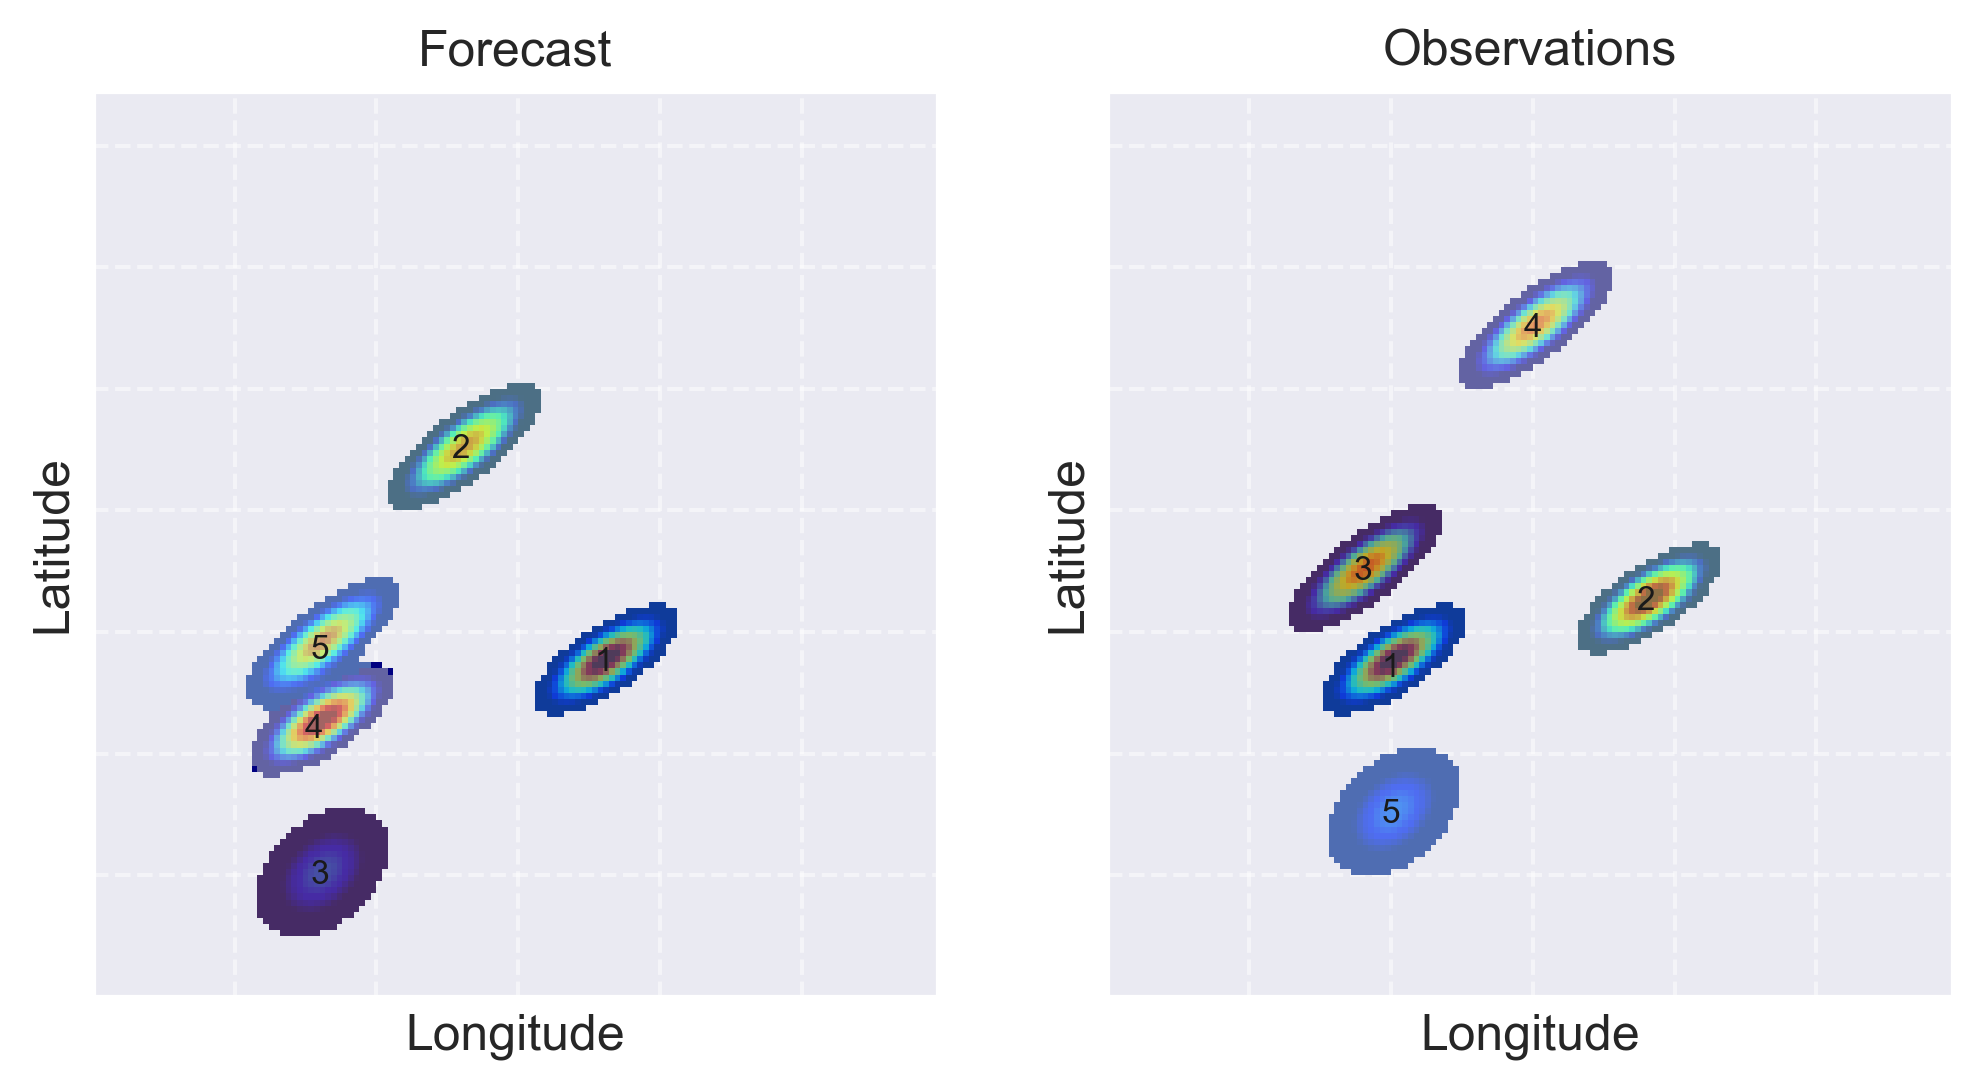

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4), dpi=300)
for i, (ax, storms, title) in enumerate(zip(axes.flat, 
                             [forecast_storms, obs_storms], 
                             ['Forecast', 'Observations'], 
                             )):
    ax.set_title(title)
    monte_python.plot_fake_storms(x,y,storms, ax=ax, colorbar=False)
    monte_python.plot_storm_labels(x, y, labels[i][0], labels[i][1], ax=ax, alpha=0.5,) 

Once we have identified objects in the forecast and observations, we can match them together. MontePython uses the total interest score from [Skinner et al. (2018)](https://journals.ametsoc.org/view/journals/wefo/33/5/waf-d-18-0020_1.xml), which uses a combination of minimum, centroid, (and optionally temporal) displacement to match objects together. For this example, we are matching objects based on centroid and minimum displacement with both thresholds set to identical values.

</div> <div class="alert alert-block alert-warning"><b>Note: The assigned labels are artibrary. Thus, there is no inherit connection between object 1 in the forecast and the observations. When matching the objects, we do not consider the labels. </b> 
    
</div> <div class="alert alert-block alert-warning"><b>Note: If you set the cent_dist_max = None, the object mathcing will be solely based on minimum displacement. </b>   

In [20]:
matcher = monte_python.ObjectMatcher(cent_dist_max = 10, 
                                       min_dist_max = 10, time_max=0, score_thresh=0.2, 
                           one_to_one = True)

# Match the objects
labels_fcst = labels[0][0]
labels_obs = labels[1][0]

matched_fcst, matched_obs, dists = matcher.match(labels_fcst, labels_obs)

`matcher.match` returns the labels that were labels matched in both sets and the tuples of dy,dx displacements between the matched pairs. We can plot those displacements with built-code. 

<AxesSubplot:xlabel='X-displacement', ylabel='Y-displacement'>

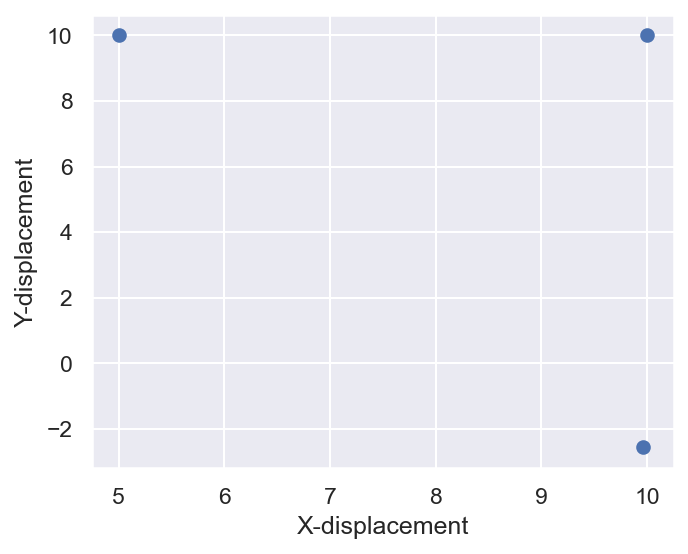

In [21]:
monte_python.plot_displacement(dists)

In [22]:
label_cent_fcst = monte_python.get_centroid_coords(labels[0][1])    
label_cent_obs = monte_python.get_centroid_coords(labels[1][1])    
x_set, y_set = monte_python.matching_path(label_cent_fcst, label_cent_obs, matched_fcst, matched_obs)

## One-to-One Matching

When matching forecast and observed storms, we may require that pairs between the two datasets be unique. I.e., One forecast storm can be matched to a single observed storms and vice versa. To ensure one-to-one matching, set `one_to_one = True` in `monte_python.ObjectMatcher`.


Text(0.5, 1.0, 'Example of One-to-One Matching')

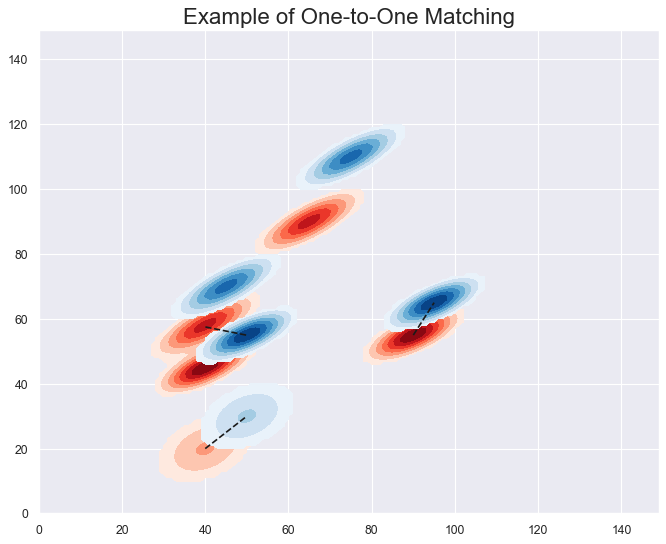

In [23]:
# Plot the matching path
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(x, y, np.ma.array(forecast_storms, mask=labels[0][0] == 0), cmap='Reds')
plt.contourf(x, y, np.ma.array(obs_storms, mask=labels[1][0] == 0), cmap='Blues')
for x1, y1 in zip(x_set, y_set):
    plt.plot(x1,y1, linestyle='dashed', color='k')

plt.title('Example of One-to-One Matching', fontsize=20)

## Non-One-to-One Matching

In some circumstances, we may want to allow for non-one-to-one matching. E.g., we may want to allow for multiple observed storms to be matched to a single forecast object. This technique was used to match observed rotation tracks to forecast ensemble tracks in [Flora et al. (2019)](https://journals.ametsoc.org/view/journals/wefo/34/6/waf-d-19-0094_1.xml) where multiple observed tracks fell within a single forecast track. To ensure non-one-to-one matching, set `one_to_one = False` in `monte_python.ObjectMatcher`.


In [24]:
matcher = monte_python.ObjectMatcher(cent_dist_max = 10, 
                                     min_dist_max = 10, 
                                     time_max=0, score_thresh=0.2, 
                                     one_to_one = False)

# Match the objects 
matched_fcst, matched_obs, _ = matcher.match(labels_fcst, labels_obs)

Text(0.7, 0.2, 'Two observed storms matched to a single forecast storm')

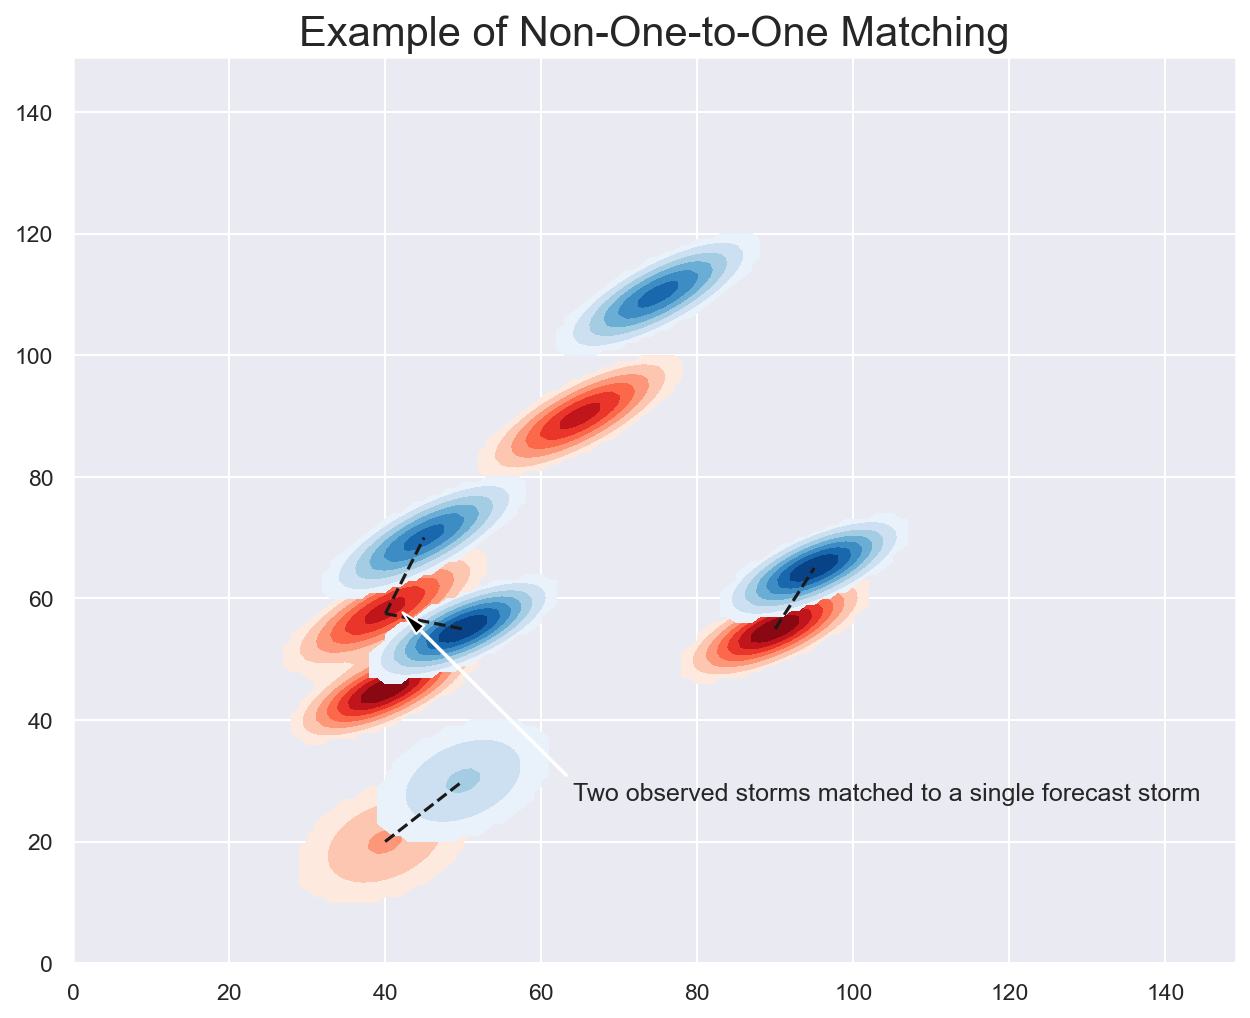

In [15]:
x_set, y_set = monte_python.matching_path(label_cent_fcst, label_cent_obs, matched_fcst, matched_obs)
# Plot the matching path
fig=plt.figure(figsize=(10, 8), dpi= 150, facecolor='w', edgecolor='k')
plt.contourf(x, y, np.ma.array(forecast_storms, mask=labels[0][0] == 0), cmap='Reds')
plt.contourf(x, y, np.ma.array(obs_storms, mask=labels[1][0] == 0), cmap='Blues')
for x1, y1 in zip(x_set, y_set):
    plt.plot(x1,y1, linestyle='dashed', color='k')

plt.title('Example of Non-One-to-One Matching', fontsize=20)

plt.annotate('Two observed storms matched to a single forecast storm', 
                 xy = (42,58), xycoords='data',
                 xytext=(0.7, 0.2), textcoords='axes fraction',
                  arrowprops=dict(facecolor='black', shrink=0.01, width=0.7, headwidth=5.5),
            horizontalalignment='center', verticalalignment='top')